In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
np.random.seed(103)
from collections import deque
from sklearn.preprocessing import StandardScaler
import os
import time
import random

class Market:
    def __init__(self, state_size, stock_name):
        self.state_size=state_size
        self.rawdata = self.get_stock_data(stock_name)
        self.states,self.data = self.get_states(self.rawdata, self.state_size)
        self.index = 0
        self.last_data_index = len(self.data)-1 #123
        self.bought_price=None
        self.total_profit=0
        self.myrewards=[]
        self.episodereward=0
        
    def get_stock_data(self, stock_name):
        vec = []
        lines = open("data/" + stock_name + ".csv", "r").read().splitlines()
        for line in lines[1:]:
            vec.append(float(line.split(",")[4]))
        return vec  #list of adj close prices

    def get_states(self,data,state_size):
        n_steps=state_size
        X = []
        Y = []
        for i in range(n_steps, len(data)):
            #X.append([2*i])
            X.append([i])
            #Y.append(data[i])
            Y.append(data[i])
        
        return np.array(X), np.array(Y)

    def reset(self):
        self.states,self.data = self.get_states(self.rawdata, self.state_size)
        self.index = 0
        self.bought_price=None
        self.total_profit=0
        self.episodereward=0
        
        return self.states[self.index], self.data[self.index]

    def get_next_state_reward(self, action,bought_price):
        

        self.index += 1
        if self.index > self.last_data_index:
            self.index = 0
        next_state = self.states[self.index ]
        next_price_data = self.data[self.index]

        price_data = self.data[self.index-1]
        reward = 0
        if action==2 and bought_price is not None: #action2=selling, 0=hold,1=buy
            reward = max(100*(price_data - bought_price)/bought_price, 0)

        done = True if self.index == self.last_data_index - 1 else False
        next_state = self.states[self.index]
        self.myrewards.append(reward)
        self.episodereward+=reward

        return next_state, next_price_data, reward, done

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):

        self.action_history = []
        self.state_size = state_size+1  # normalized previous days
        self.action_size = 3  # hold, buy, sell
        self.memory = deque(maxlen=2000)
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.995
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.005 # 0.00005 for 5years
        self.model = load_model(model_name) if is_eval else self.create_model()
        self.target_model=self.create_model() #####
        self.target_model.set_weights(self.model.get_weights())
        self.batch_size = 64
        self.train_start=500
        self.mystates=[]
        self.myactions=[]
        self.myprices=[]
        self.__inventory=[]
        self.__total_profit=0
        
    def create_model(self):
        model = Sequential()
        model.add(Dense(units=24, input_dim=62, activation="relu"))
        model.add(Dense(units=24, activation="relu"))
        model.add(Dense(units=12, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
   
    def reset(self): #reset after each episode
        self.mystates = []
        self.myactions=[]
        self.myprices=[]
        self.__inventory=[]
        self.__total_profit=0
        
        
    def get_action(self, state, price_data):
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(self.action_size)
        else:
            action = np.argmax(self.model.predict(state.reshape(1, len(market.data)))) ## was [0]
            
        bought_price = None
        
        if action == 0: #hold 
            self.action_history.append(action)
            
        elif action == 1 and len(self.__inventory)<1:  #buy   #####
            self.__inventory.append(price_data)
            #print("Buy: {0}".format(self.format_price(price_data)))
            self.action_history.append(action)
            
        elif action == 2 and len(self.__inventory) > 0:  #sell
            bought_price = self.__inventory.pop(0)
            self.__total_profit += 100*(price_data - bought_price)/bought_price
            #print("Sell: {0}".format(self.format_price(price_data) ))
            self.action_history.append(action)
            
        else: # action is 2 (sell) but we don't have anything in inventory to sell!
            self.action_history.append(0)
            
        return action, bought_price
            
    def experience_replay(self):
        mini_batch=random.sample(self.memory,self.batch_size)

        states, actions, rewards, states_next, dones = zip(*mini_batch)

        states = np.concatenate(states)
        states_next = np.concatenate(states_next)

        q_values = self.model.predict(states)
        q_values_next = self.target_model.predict(states_next)

        for i in range(self.batch_size):
            a = actions[i]
            done = dones[i]
            if done:
                q_values[i][a] = rewards[i]
            else:
                q_values[i][a] = rewards[i] + self.gamma * np.max(q_values_next[i])

        self.model.fit(states, q_values, epochs=1,verbose=1)
        
        self.target_model.set_weights(self.model.get_weights())    
        
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay            
            
            

    def format_price(self, n):
        return ("-" if n < 0 else "") + "{0:.3f}".format(abs(n))

    def train(self):
        start_time = time.time()
        for e in range(episodes + 1):
            print("Episode " + str(e) + "/" + str(episodes))
            agent.reset()
            state, price_data = market.reset() 
            state = to_categorical(state, num_classes=len(market.data))
            state = state.reshape(1, len(market.data))
            while True:
                
                action,bought_price= agent.get_action(state,price_data)
                
                next_state, next_price_data, reward, done = market.get_next_state_reward(action,bought_price)
                
                self.mystates.append(np.argmax(state))
                self.myactions.append(action)
                self.myprices.append(market.data[np.argmax(state)])
                
                next_state = to_categorical(next_state, num_classes=len(market.data))
                
                
                next_state = next_state.reshape(1, len(market.data))
                #state = state.reshape(1, len(market.data))
                
                self.memory.append((state, action, reward, next_state, done))
                
                state = next_state
                price_data = next_price_data

                
                if done:
                    if e % 50 == 0:
                        if not os.path.exists("models"):
                            os.mkdir("models")
                            self.model.save("models/model_ep" + str(e))
                if done and len(self.memory)>self.train_start:
                    
                    self.experience_replay()    
                    print("Total Profit %: {0}, Epsilon @end: {1}, Number of sells: {2}, Sumreward: {3}" .format(self.format_price(agent.__total_profit),self.format_price( self.epsilon),self.myactions.count(2), market.episodereward))
                    #print("Number of sells: {}" .format(self.action_history.count(2)))
                    if e % 50 == 0:
                        if not os.path.exists("models"):
                            os.mkdir("models")
                            self.model.save("models/model_ep" + str(e))
                    break
                    
        end_time = time.time()
        print("Training took {0} seconds.".format(round(end_time - start_time)))

In [34]:
#if __name__ == "__main__":
state_size = 0 ##
episodes = 600
stock_name = "GSPC_2011-03"
agent = Agent(state_size)
market = Market(state_size=state_size, stock_name=stock_name)
agent.train()

Episode 0/600
64/64 [==============================] - 0s 7ms/sample - loss: 0.0419
Total Profit %: 9.716, Epsilon @end: 0.995, Number of sells: 181, Sumreward: 55.70202150045395
Episode 1/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0353
Total Profit %: -3.842, Epsilon @end: 0.990, Number of sells: 25, Sumreward: 2.101278019247103
Episode 2/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0637
Total Profit %: -2.298, Epsilon @end: 0.985, Number of sells: 24, Sumreward: 4.164390562944452
Episode 3/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0350
Total Profit %: 1.512, Epsilon @end: 0.980, Number of sells: 22, Sumreward: 5.450130763424577
Episode 4/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0552
Total Profit %: -1.255, Epsilon @end: 0.975, Number of sells: 27, Sumreward: 3.725819051420588
Episode 5/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0435
Total Profit %:

64/64 [==============================] - 0s 244us/sample - loss: 0.0783
Total Profit %: 3.383, Epsilon @end: 0.540, Number of sells: 32, Sumreward: 6.177142475928703
Episode 92/600
64/64 [==============================] - 0s 245us/sample - loss: 0.0530
Total Profit %: -2.893, Epsilon @end: 0.535, Number of sells: 37, Sumreward: 2.5135309570212048
Episode 93/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0521
Total Profit %: 3.641, Epsilon @end: 0.530, Number of sells: 38, Sumreward: 4.477939310085064
Episode 94/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0993
Total Profit %: 4.395, Epsilon @end: 0.525, Number of sells: 39, Sumreward: 4.806046342854337
Episode 95/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0964
Total Profit %: 7.131, Epsilon @end: 0.520, Number of sells: 31, Sumreward: 7.415402577452389
Episode 96/600
64/64 [==============================] - 0s 0s/sample - loss: 0.1720
Total Profit %: 1.759, Epsilon

64/64 [==============================] - 0s 244us/sample - loss: 0.0515
Total Profit %: 2.031, Epsilon @end: 0.090, Number of sells: 49, Sumreward: 2.031344900643758
Episode 182/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0567
Total Profit %: 2.031, Epsilon @end: 0.085, Number of sells: 50, Sumreward: 2.031344900643758
Episode 183/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0560
Total Profit %: 3.536, Epsilon @end: 0.080, Number of sells: 49, Sumreward: 3.5363887435968935
Episode 184/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0506
Total Profit %: 3.405, Epsilon @end: 0.075, Number of sells: 47, Sumreward: 3.5363887435968935
Episode 185/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0844
Total Profit %: 1.725, Epsilon @end: 0.070, Number of sells: 44, Sumreward: 1.8561864086710187
Episode 186/600
64/64 [==============================] - 0s 346us/sample - loss: 0.0490
Total Profit %: -1

64/64 [==============================] - 0s 244us/sample - loss: 0.0283
Total Profit %: 3.686, Epsilon @end: 0.010, Number of sells: 33, Sumreward: 8.02445740128735
Episode 272/600
64/64 [==============================] - 0s 245us/sample - loss: 0.0373
Total Profit %: 1.893, Epsilon @end: 0.010, Number of sells: 31, Sumreward: 6.076130782473443
Episode 273/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0251
Total Profit %: 1.282, Epsilon @end: 0.010, Number of sells: 30, Sumreward: 5.730134922694121
Episode 274/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0449
Total Profit %: 2.444, Epsilon @end: 0.010, Number of sells: 25, Sumreward: 6.309506851355858
Episode 275/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0151
Total Profit %: -1.557, Epsilon @end: 0.010, Number of sells: 22, Sumreward: 3.0836618953721615
Episode 276/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0261
Total Profit %: -0.6

64/64 [==============================] - 0s 0s/sample - loss: 0.0084
Total Profit %: 2.259, Epsilon @end: 0.010, Number of sells: 33, Sumreward: 3.534561220310863
Episode 362/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0109
Total Profit %: 2.259, Epsilon @end: 0.010, Number of sells: 32, Sumreward: 3.534561220310863
Episode 363/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0104
Total Profit %: 2.259, Epsilon @end: 0.010, Number of sells: 32, Sumreward: 3.534561220310863
Episode 364/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0154
Total Profit %: 0.453, Epsilon @end: 0.010, Number of sells: 31, Sumreward: 2.094320014546657
Episode 365/600
64/64 [==============================] - 0s 245us/sample - loss: 0.0142
Total Profit %: 2.259, Epsilon @end: 0.010, Number of sells: 32, Sumreward: 3.534561220310863
Episode 366/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0076
Total Profit %: 1.245, Epsilon

Total Profit %: 0.655, Epsilon @end: 0.010, Number of sells: 21, Sumreward: 4.418225744934781
Episode 451/600
64/64 [==============================] - 0s 488us/sample - loss: 0.0119
Total Profit %: 0.482, Epsilon @end: 0.010, Number of sells: 21, Sumreward: 4.245255943882115
Episode 452/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0062
Total Profit %: -0.428, Epsilon @end: 0.010, Number of sells: 23, Sumreward: 3.8231884218530228
Episode 453/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0057
Total Profit %: -2.505, Epsilon @end: 0.010, Number of sells: 25, Sumreward: 2.7685064072087746
Episode 454/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0096
Total Profit %: -0.793, Epsilon @end: 0.010, Number of sells: 26, Sumreward: 3.4576544947701695
Episode 455/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0028
Total Profit %: -1.608, Epsilon @end: 0.010, Number of sells: 29, Sumreward: 2.1912524280146513


64/64 [==============================] - 0s 245us/sample - loss: 0.0059
Total Profit %: -1.139, Epsilon @end: 0.010, Number of sells: 30, Sumreward: 3.5977511812462355
Episode 497/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0063
Total Profit %: -0.203, Epsilon @end: 0.010, Number of sells: 33, Sumreward: 4.048067071447953
Episode 498/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0060
Total Profit %: -0.489, Epsilon @end: 0.010, Number of sells: 36, Sumreward: 3.497329931824778
Episode 499/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0045
Total Profit %: -1.859, Epsilon @end: 0.010, Number of sells: 40, Sumreward: 2.1273946314918097
Episode 500/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0081
Total Profit %: -2.666, Epsilon @end: 0.010, Number of sells: 41, Sumreward: 1.614617000577424
Episode 501/600
64/64 [==============================] - 0s 102us/sample - loss: 0.0074
Total Profit %: -2.1

64/64 [==============================] - 0s 244us/sample - loss: 0.0048
Total Profit %: -1.679, Epsilon @end: 0.010, Number of sells: 34, Sumreward: 3.388550896353946
Episode 542/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0104
Total Profit %: 0.796, Epsilon @end: 0.010, Number of sells: 34, Sumreward: 3.810752807012797
Episode 543/600
64/64 [==============================] - 0s 244us/sample - loss: 0.0250
Total Profit %: 2.248, Epsilon @end: 0.010, Number of sells: 40, Sumreward: 3.3950782719026193
Episode 544/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0052
Total Profit %: 2.020, Epsilon @end: 0.010, Number of sells: 43, Sumreward: 3.0263248601201607
Episode 545/600
64/64 [==============================] - 0s 346us/sample - loss: 0.0205
Total Profit %: 2.129, Epsilon @end: 0.010, Number of sells: 44, Sumreward: 2.2600690614672168
Episode 546/600
64/64 [==============================] - 0s 0s/sample - loss: 0.0035
Total Profit %: 0.35

In [35]:
len(market.data)

62

In [ ]:
#agent.myprices

(array([3.4481e+04, 1.1080e+03, 6.7700e+02, 1.6200e+02, 1.0200e+02,
        1.2000e+01, 4.0000e+00, 8.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.41376169, 0.82752338, 1.24128507, 1.65504676,
        2.06880844, 2.48257013, 2.89633182, 3.31009351, 3.7238552 ,
        4.13761689]),
 <a list of 10 Patch objects>)

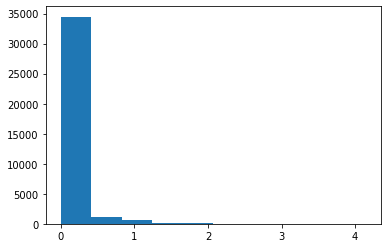

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
#states, actions, rewards, states_next, dones = zip(*agent.memory)
plt.hist(market.myrewards)


In [37]:
def plot_action_profit(data, action_data, profit):
    plt.plot(range(len(data)), data)
    plt.xlabel("date")
    plt.ylabel("price")
    buy, sel = False, False
    for d in range(len(data) -1):
        if action_data[d] == 1:  # buy
            buy, = plt.plot(d, data[d], 'g*')
        elif action_data[d] == 2:  # sell
            sel, = plt.plot(d, data[d], 'r*')
    if buy and sel:
        plt.legend([buy, sel], ["Buy", "Sell"])
    plt.title("Number of sells: {0}, Nr of buys {1}, Total Profit%: {2}".format(action_data.count(2),action_data.count(1),market.total_profit))
    plt.savefig("buy_sell.png")
    plt.show()


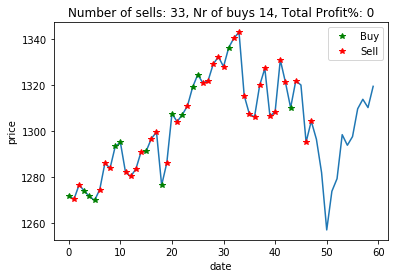

In [38]:
    plot_action_profit(agent.myprices, agent.myactions, 100)